In [2]:
import os
import zipfile
import subprocess
from glob import glob
import rasterio
import matplotlib.pyplot as plt
import numpy as np


## Sentinel-2

In [18]:
dir=os.getcwd()
def unzip_all(folder):
    for file in os.listdir(folder):
        if file.endswith('.zip'):
            zip_path = os.path.join(folder, file)
            extract_folder = os.path.join(folder, file.replace('.zip', ''))

            if os.path.exists(extract_folder) and os.listdir(extract_folder):
                print(f'Вже розпаковано: {file}')
                continue

            print(f'Розпакування файла: {file}')
            os.makedirs(extract_folder, exist_ok=True)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
            print(f'Розпаковано файл: {file}')

unzip_all(dir)
unzip_all(f'{dir}\Sentinel-2')

Вже розпаковано: Sentinel-2.zip
Вже розпаковано: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip
Вже розпаковано: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip


In [19]:
base_dir = r'.\Sentinel-2'
shapefile = os.path.join(base_dir, 'Kyiv_regions.shp')

for name in ["merged_all.tif", "final_clipped.tif"]:
    path = os.path.join(base_dir, name)
    if os.path.exists(path):
        os.remove(path)

safe_dirs = []
for sub in os.listdir(base_dir):
    full_sub = os.path.join(base_dir, sub)
    if os.path.isdir(full_sub):
        for item in os.listdir(full_sub):
            if item.endswith('.SAFE'):
                safe_dirs.append(os.path.join(full_sub, item))

merged_list = []

# Обробка кожної сцени
for i, safe in enumerate(safe_dirs):
    r10m_path = glob(os.path.join(safe, 'GRANULE', '*', 'IMG_DATA', 'R10m'))[0]

    b2 = glob(os.path.join(r10m_path, '*_B02_10m.jp2'))[0]
    b3 = glob(os.path.join(r10m_path, '*_B03_10m.jp2'))[0]
    b4 = glob(os.path.join(r10m_path, '*_B04_10m.jp2'))[0]
    b8 = glob(os.path.join(r10m_path, '*_B08_10m.jp2'))[0]

    merged_tif = os.path.join(base_dir, f'merged_{i}.tif')
    subprocess.run([
        'python', r'D:\Program Files\Anaconda\envs\gdal_env\Scripts\gdal_merge.py',
        '-separate', '-o', merged_tif, b2, b3, b4, b8
    ], check=True)

    projected_tif = merged_tif.replace('.tif', '_4326.tif')
    subprocess.run([
        r'D:\Program Files\Anaconda\envs\gdal_env\Library\bin\gdalwarp.exe',
        '-s_srs', 'EPSG:32636',
        '-t_srs', 'EPSG:4326',
        merged_tif, projected_tif
    ], check=True)

    merged_list.append(projected_tif)


merged_all = os.path.join(base_dir, 'merged_all.tif')
subprocess.run([
    r'D:\Program Files\Anaconda\envs\gdal_env\Library\bin\gdalwarp.exe',
    '-of', 'GTiff', '-overwrite', '-multi', '-dstalpha', '-r', 'bilinear'
] + merged_list + [merged_all], check=True)


clipped = os.path.join(base_dir, 'final_clipped.tif')
subprocess.run([
    r'D:\Program Files\Anaconda\envs\gdal_env\Library\bin\gdalwarp.exe',
    '-cutline', shapefile, '-crop_to_cutline', '-dstnodata', '0', '-of', 'GTiff', merged_all, clipped
], check=True)



CompletedProcess(args=['D:\\Program Files\\Anaconda\\envs\\gdal_env\\Library\\bin\\gdalwarp.exe', '-cutline', '.\\Sentinel-2\\Kyiv_regions.shp', '-crop_to_cutline', '-dstnodata', '0', '-of', 'GTiff', '.\\Sentinel-2\\merged_all.tif', '.\\Sentinel-2\\final_clipped.tif'], returncode=0)

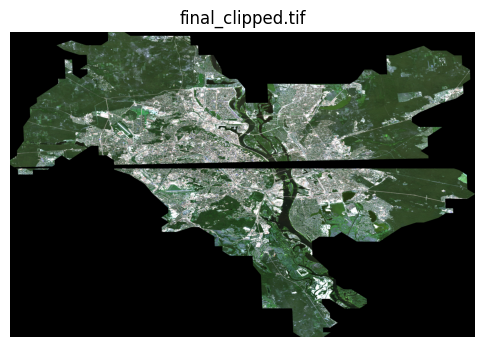

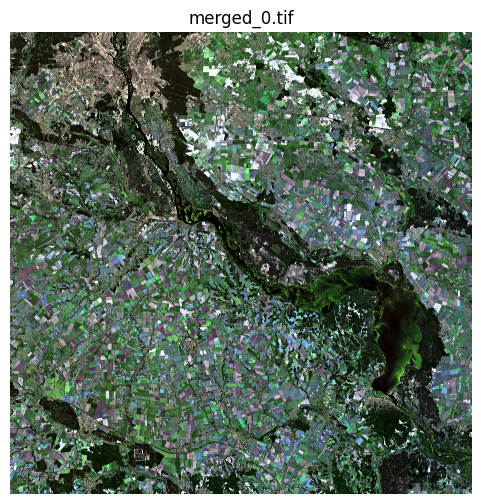

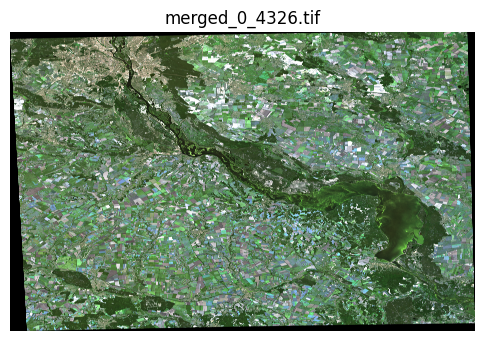

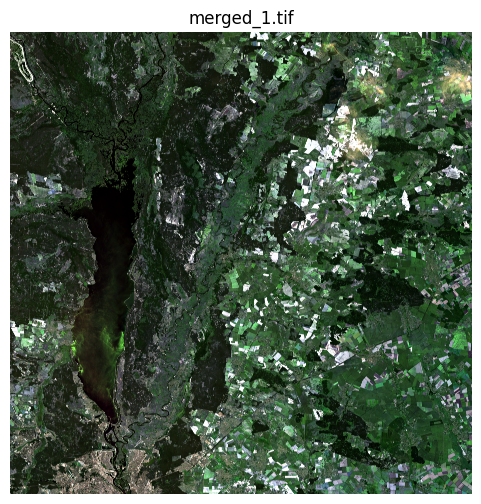

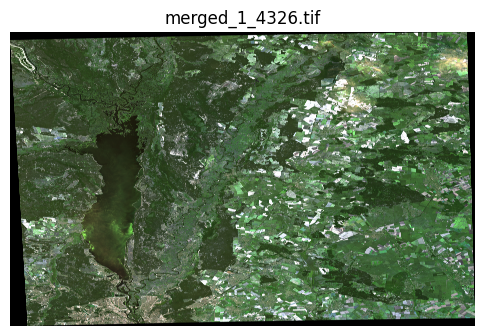

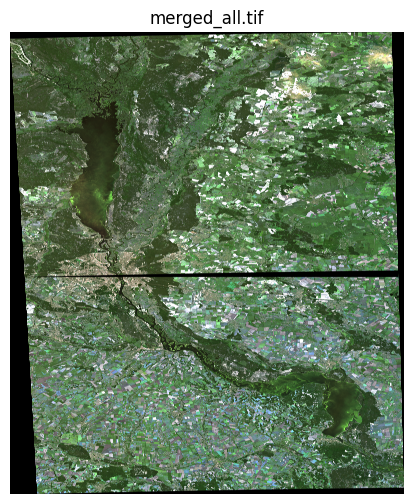

In [21]:
tif_files = [
    os.path.join(base_dir, f) for f in os.listdir(base_dir)
    if f.endswith('.tif')
]

for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        bands = src.read([1, 2, 3])
        def normalize(channel):
            p2, p98 = np.percentile(channel, (2, 98))
            return np.clip((channel - p2) / (p98 - p2), 0, 1)
        bands_norm = np.stack([normalize(band) for band in bands])
        img = bands_norm.transpose(1, 2, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(os.path.basename(tif_path))
        plt.axis('off')
        plt.show()

##  Landsat-8

In [ ]:
import subprocess
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import tarfile

In [ ]:
def untar_all(folder):
    for file in os.listdir(folder):
        if file.endswith('.tar'):
            tar_path = os.path.join(folder, file)
            extract_folder = os.path.join(folder, file.replace('.tar', ''))

            if os.path.exists(extract_folder) and os.listdir(extract_folder):
                print(f"Файл вже розпаковано: {file}")
                continue

            print(f'Розпаковується файл: {file}')
            os.makedirs(extract_folder, exist_ok=True)
            with tarfile.open(tar_path, 'r') as tar_ref:
                tar_ref.extractall(path=extract_folder)
            print(f'Розпаковано файл: {file}')

untar_all(dir)


Файл вже розпаковано: LC08_L1TP_182025_20190830_20200826_02_T1.tar


In [22]:
python = r"d:\Program Files\Anaconda\envs\gdal_env\python.exe"
gdal_merge = r"d:\Program Files\Anaconda\envs\gdal_env\Scripts\gdal_merge.py"
gdal_pansharpen = r"d:\Program Files\Anaconda\envs\gdal_env\Scripts\gdal_pansharpen.py"

landsat_dir = f"{dir}\LC08_L1TP_182025_20190830_20200826_02_T1"
res_dir = f"{dir}\landsat_result"
os.makedirs(res_dir, exist_ok=True)

rgb_bands = ["B2", "B3", "B4"] 
pan_band = "B8"                

scene = os.path.basename(landsat_dir)
rgb_paths = [os.path.join(landsat_dir, f"{scene}_{b}.TIF") for b in rgb_bands]
pan_path = os.path.join(landsat_dir, f"{scene}_{pan_band}.TIF")

rgb_merged = os.path.join(res_dir, "rgb.tif")
subprocess.run([python, gdal_merge, "-separate", "-o", rgb_merged] + rgb_paths)

pan_30 = os.path.join(res_dir, "pan_30m.tif")
rgb_60 = os.path.join(res_dir, "rgb_60m.tif")
subprocess.run(["gdal_translate", "-tr", "30", "30", "-r", "cubic", pan_path, pan_30])
subprocess.run(["gdal_translate", "-tr", "60", "60", "-r", "cubic", rgb_merged, rgb_60])

methods = ["nearest", "bilinear", "cubic", "cubicspline", "lanczos", "average"]
sharpened_paths = {}
for method in methods:
    out_path = os.path.join(res_dir, f"pansharpened_{method}.tif")
    subprocess.run([python, gdal_pansharpen, "-r", method, pan_30, rgb_60, out_path])
    sharpened_paths[method] = out_path

def read_raster(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f" Файл не знайдено: {path}")
    with rasterio.open(path) as src:
        return src.read().astype(np.float32)

def calculate_metrics(original, sharpened):
    r2, rmse, mae = [], [], []
    for i in range(original.shape[0]):
        o, s = original[i].flatten(), sharpened[i].flatten()
        r2.append(r2_score(o, s))
        rmse.append(np.sqrt(mean_squared_error(o, s)))
        mae.append(mean_absolute_error(o, s))
    return {
        "r2": np.mean(r2),
        "rmse": np.mean(rmse),
        "mae": np.mean(mae)
    }

original = read_raster(rgb_merged)
results = {method: calculate_metrics(original, read_raster(path)) for method, path in sharpened_paths.items()}

df = pd.DataFrame([
    [method, f"{m['r2']:.4f}", f"{m['rmse']:.2f}", f"{m['mae']:.2f}"]
    for method, m in results.items()
], columns=["Метод", "R² ", "RMSE ", "MAE "])

print(df)

best_r2 = max(results, key=lambda x: results[x]['r2'])
best_rmse = min(results, key=lambda x: results[x]['rmse'])
best_mae = min(results, key=lambda x: results[x]['mae'])

print(f"\n Найкращий за R²: {best_r2} (R² = {results[best_r2]['r2']:.4f})")
print(f" Найкращий за RMSE: {best_rmse} (RMSE = {results[best_rmse]['rmse']:.2f})")
print(f" Найкращий за MAE: {best_mae} (MAE = {results[best_mae]['mae']:.2f})")


         Метод     R²    RMSE     MAE 
0      nearest  0.9952  277.70  184.84
1     bilinear  0.9936  320.41  187.72
2        cubic  0.9936  319.38  187.22
3  cubicspline  0.9913  371.74  192.74
4      lanczos  0.9936  318.95  187.02
5      average  0.9943  302.50  186.30

 Найкращий за R²: nearest (R² = 0.9952)
 Найкращий за RMSE: nearest (RMSE = 277.70)
 Найкращий за MAE: nearest (MAE = 184.84)


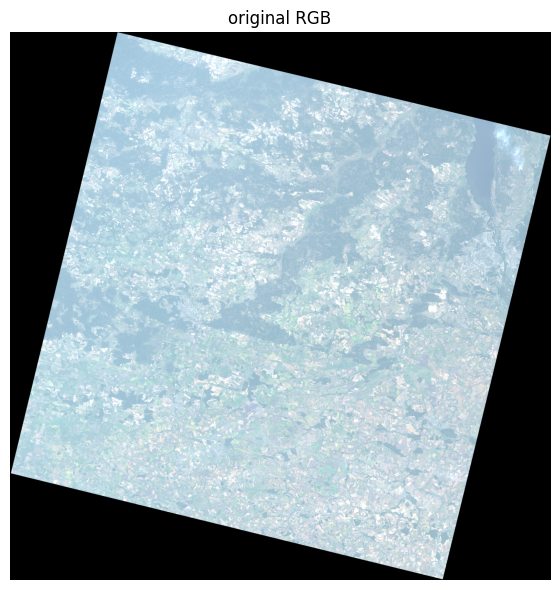

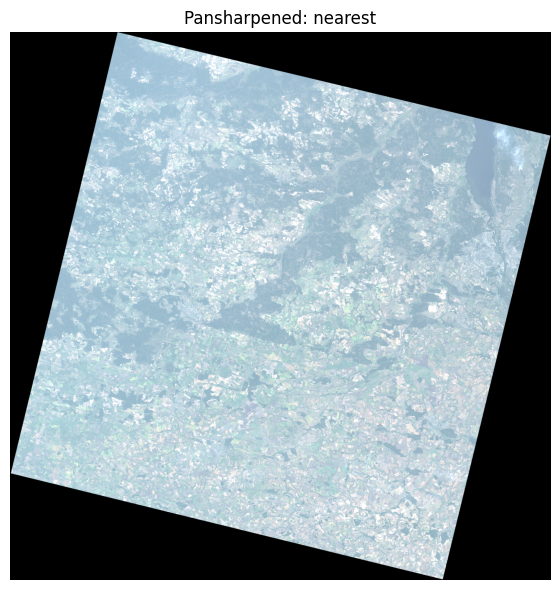

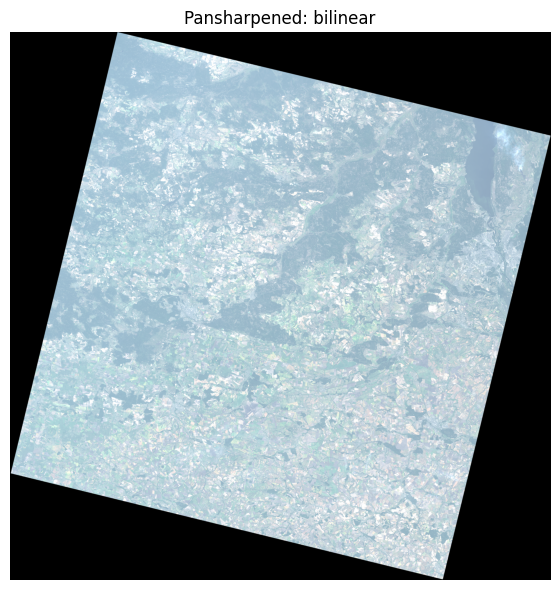

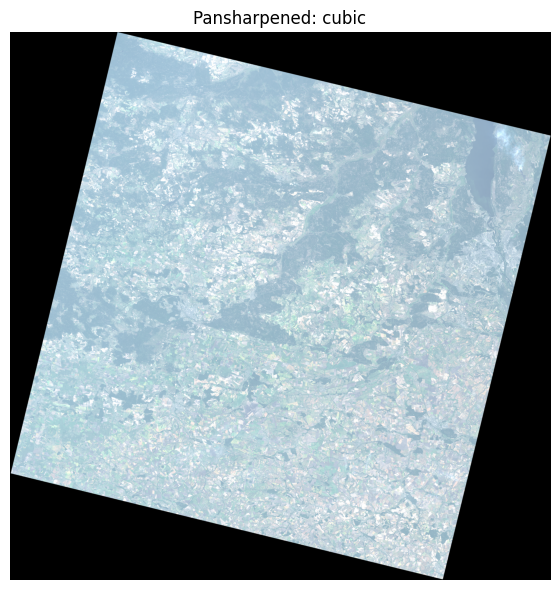

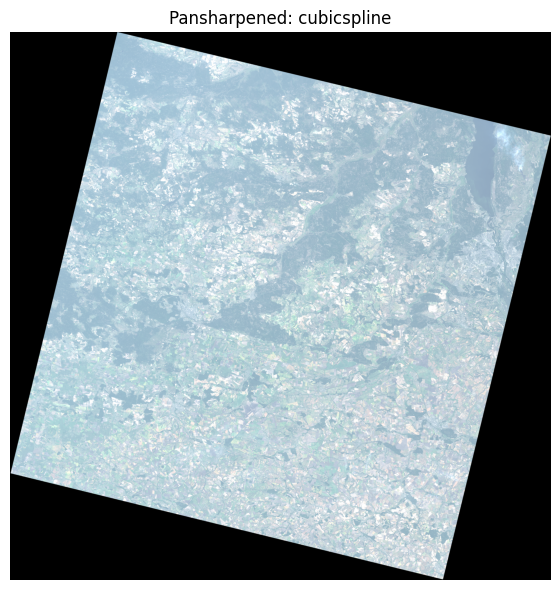

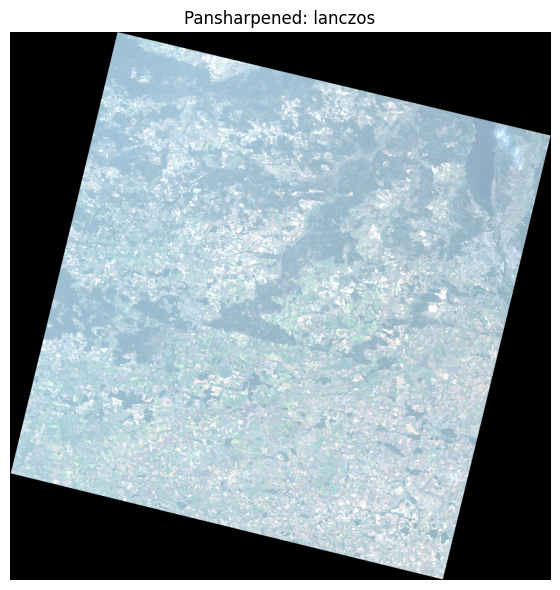

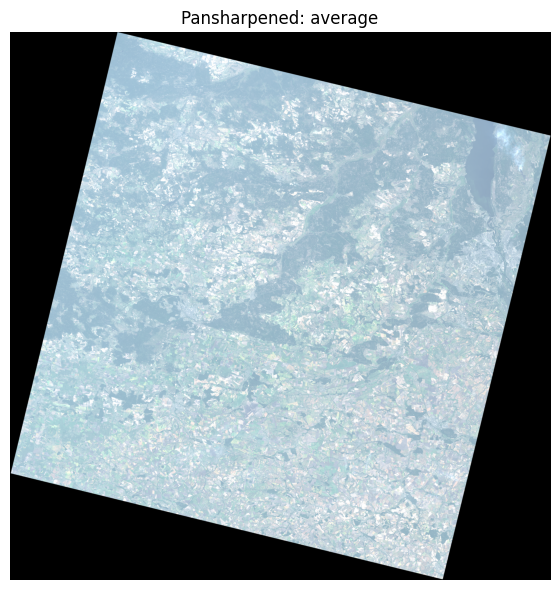

In [23]:
def normalize(channel):
    p2, p98 = np.percentile(channel, (2, 98))
    return np.clip((channel - p2) / (p98 - p2), 0, 1)

def show_rgb_image(path, title):
    with rasterio.open(path) as src:
        rgb = src.read([3, 2, 1])  # R, G, B
        rgb_norm = np.stack([normalize(b) for b in rgb])
        img = rgb_norm.transpose(1, 2, 0)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

show_rgb_image(rgb_merged, f'original RGB')

for method, path in sharpened_paths.items():
    show_rgb_image(path, f"Pansharpened: {method}")